In [1]:
import numpy as np
import librosa
from scipy.io.wavfile import read, write
from matplotlib import pyplot as plt
import scipy.ndimage
import IPython.display as display
from tqdm import tqdm

In [2]:
audio, rate = librosa.load('./vikanikita.wav')
print(rate)

22050


In [3]:
def resample(audio, scale=2):
    subscaled = audio[::scale]
    return scipy.ndimage.zoom(subscaled, scale)

In [4]:
display.Audio(audio, rate=rate)

In [5]:
audio_11khz = resample(audio, 2)
audio_5500hz = resample(audio, 4)
audio_2750hz = resample(audio, 8)
audio_1375hz = resample(audio, 16)
audio_345hz = resample(audio, 64)

In [6]:
display.Audio(audio_2750hz, rate=rate)

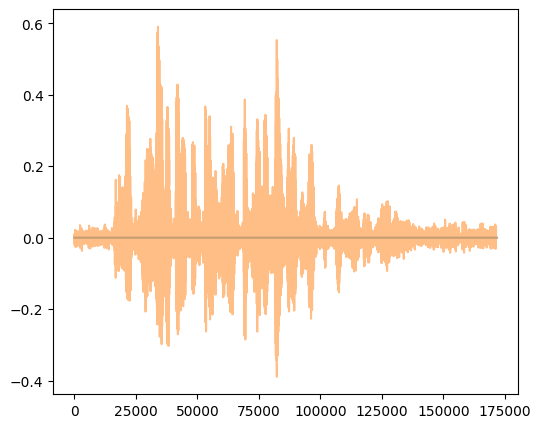

In [7]:
reconstruct = librosa.stft(audio)
spectrogram = np.abs(reconstruct)
phase = np.angle(reconstruct)
restored_audio = librosa.istft(spectrogram * np.exp(1j * phase))

plt.figure(figsize=(6, 5))
plt.plot(audio / 2**15, alpha=0.5)
plt.plot(restored_audio, alpha=0.5)

## Griffin-Lim algorithm

In [8]:
def griffin_lim(spectrogram, iterations=10):
    eps = 1e-6
    phase = 2 * np.pi * np.random.uniform(size=spectrogram.shape)
    restored = spectrogram * np.exp(1j * phase)
    for iteration in range(iterations):
        prev_rest = restored
        inv = librosa.istft(restored, n_fft=2048)
        reconstruct = librosa.stft(inv, n_fft=2048)
        restored = spectrogram * reconstruct / (np.abs(reconstruct) + eps)
        mse = sum((librosa.istft(restored) - librosa.istft(prev_rest))**2)
        print(f"iteration: {iteration}; MSE: {mse}")
        
    return librosa.istft(restored)

In [9]:
audio_iter1 = griffin_lim(spectrogram, iterations=10)
display.Audio(audio_iter1, rate=rate)

iteration: 0; MSE: 121.01961908046452
iteration: 1; MSE: 13.771745983519613
iteration: 2; MSE: 7.040149431242146
iteration: 3; MSE: 4.662756508025636
iteration: 4; MSE: 3.019705916988878
iteration: 5; MSE: 2.217453906663962
iteration: 6; MSE: 1.8581028407544717
iteration: 7; MSE: 1.379496280897747
iteration: 8; MSE: 1.1279568539301432
iteration: 9; MSE: 1.0105908852050605


/tmp/ipykernel_52239/379767536.py:1: FutureWarning: Pass y=[0.00725397 0.00779247 0.00786264 ... 0.00135842 0.00192519 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(audio)


(1025, 336)


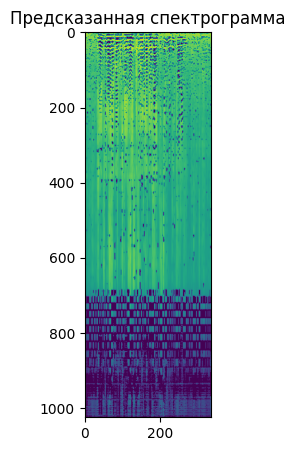

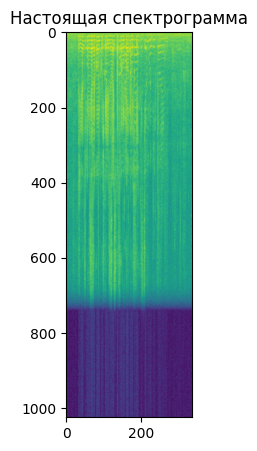

In [10]:
mel_spectrogram = librosa.feature.melspectrogram(audio)

restored_spectrogram = librosa.feature.inverse.mel_to_stft(mel_spectrogram)
print(restored_spectrogram.shape)

plt.figure(figsize=(6, 5))
plt.title('Предсказанная спектрограмма')
plt.imshow(np.log(1.e-8 + restored_spectrogram))
plt.figure(figsize=(6, 5))
plt.title('Настоящая спектрограмма')
plt.imshow(np.log(1.e-8 + spectrogram))

In [11]:
restored_audio = griffin_lim(restored_spectrogram, iterations=10)
display.Audio(restored_audio, rate=rate)

iteration: 0; MSE: 130.16933884173417
iteration: 1; MSE: 12.079120243606566
iteration: 2; MSE: 5.2232381613909755
iteration: 3; MSE: 3.076543541287267
iteration: 4; MSE: 2.0292778258372492
iteration: 5; MSE: 1.4199635759199278
iteration: 6; MSE: 1.038559308145288
iteration: 7; MSE: 0.7941766794236651
iteration: 8; MSE: 0.6415611315871449
iteration: 9; MSE: 0.5490402917649025
